# Extracting from free text with MedCAT

This tutorial serves as an introduction on how to use *ehrapy* together with [MedCAT](https://github.com/CogStack/MedCAT). *MedCat* is a tool to extract medical entities from free text and link it to biomedical ontologies. Biomedical entities could be anything biomedical; not only diagnoses or diseases but also symptoms, drugs or even peptides. 
It also tries to keep the context of an extracted entitiy (for example, whether a specific disease has been diagnosed or not). This is especially important for electronic health records data, as most of the time doctors notes are simply copied and pasted into the data and not preprocessed in any form. Consider the following example:

- The patient suffers from diabetes.

 vs.
 
- The patient does not suffer from diabetes.


In detail, ehrapy uses a pretrained and packages model from MedCat (https://medcat.readthedocs.io/en/latest/main.html#models). This model is limited in performance but good enough for this demonstration. A larger (trained) model is planned to be released somewhen in the (near) future by the MedCAT maintainers.

In [15]:
import ehrapy as ep
from medcat.cat import CAT

In [16]:
ep.settings.n_jobs = 2

Download the example data

In [ ]:
!wget -nc https://raw.githubusercontent.com/CogStack/MedCATtutorials/main/notebooks/introductory/data/pt_notes.csv -P ./medcat_data/
!wget -nc https://cogstack-medcat-example-models.s3.eu-west-2.amazonaws.com/medcat-example-models/medmen_wstatus_2021_oct.zip -P ./medcat_data/

--2023-12-12 15:54:01--  https://raw.githubusercontent.com/CogStack/MedCATtutorials/main/notebooks/introductory/data/pt_notes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3644222 (3,5M) [text/plain]
Saving to: ‘./medcat_data/pt_notes.csv’

pt_notes.csv        100%[===================>]   3,47M  22,4MB/s    in 0,2s    

2023-12-12 15:54:01 (22,4 MB/s) - ‘./medcat_data/pt_notes.csv’ saved [3644222/3644222]

--2023-12-12 15:54:02--  https://cogstack-medcat-example-models.s3.eu-west-2.amazonaws.com/medcat-example-models/medmen_wstatus_2021_oct.zip
Resolving cogstack-medcat-example-models.s3.eu-west-2.amazonaws.com (cogstack-medcat-example-models.s3.eu-west-2.amazonaws.com)... 3.5.244.164, 3.5.246.197, 52.95.149.106, ...
Connecting to cogstack-medcat-examp

First, we read the example data into an AnnData object, and perform ehrapy's encode step.

In [17]:
adata = ep.io.read_csv("medcat_data/pt_notes.csv", columns_obs_only=["text"])
adata_encoded = ep.pp.encode(adata, autodetect=True)

2023-12-14 23:16:13,116 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `1088` x `8`.
2023-12-14 23:16:13,117 - root INFO - The original categorical values `['category', 'gender']` were added to uns.


Output()

2023-12-14 23:16:13,126 - root INFO - Encoding strings in X to save to .h5ad. Loading the file will reverse the encoding.
2023-12-14 23:16:13,127 - root INFO - Updated the original layer after encoding.


2023-12-14 23:16:13,131 - root INFO - The original categorical values `['category', 'gender']` were added to obs.


## Prepare CAT object as per MedCAT workflow

To leverage MedCAT for free text processing in ehrapy, we start by creating a `CAT` object. This is described in more details in for example the [MedCAT tutorials](https://medcat.readthedocs.io/en/latest/main.html#tutorials).

Here, we simply load a pretrained model from the maintainers of MedCAT which can be downloaded & readily used.
For specific usecases, using more sophisticated refinements might be required. For this tutorial and a quick start, we will use this out-of-the-box model.

We also set some TUI filters.
A full list of TUI’s can be found at: https://lhncbc.nlm.nih.gov/ii/tools/MetaMap/Docs/SemanticTypes_2018AB.txt

In [18]:
# create the main ehrapy medcat object used for medical entitiy analysis using ehrapy and medcat
cat = CAT.load_model_pack("./medcat_data/medmen_wstatus_2021_oct.zip")

# only use diseases and behavioural disorders diagnoses in this example by filtering by TUI
tuis=["T047", "T048"]
cui_filters = set()
for type_id in tuis:
    cui_filters.update(cat.cdb.addl_info["type_id2cuis"][type_id])
cat.cdb.config.linking["filters"]["cuis"] = cui_filters


Using this model pack we can already extract entities from an example note.

In [19]:
text = "He was diagnosed with kidney failure"
doc = cat(text)
doc.ents

(kidney failure,)

In [20]:
# Example output of an extracted medcat entity; note that ehrapy will deal with this automatically and the here displayed manual extraction is not required.
# CUI: Concept Unique Identifier, which is just an unique identifier for each concept extracted
cat.get_entities("He was diagnosed with kidney failure", only_cui=False)

{'entities': {2: {'pretty_name': 'Kidney Failure',
   'cui': 'C0035078',
   'type_ids': ['T047'],
   'types': ['Disease or Syndrome'],
   'source_value': 'kidney failure',
   'detected_name': 'kidney~failure',
   'acc': 1.0,
   'context_similarity': 1.0,
   'start': 22,
   'end': 36,
   'icd10': [],
   'ontologies': [],
   'snomed': [],
   'id': 2,
   'meta_anns': {'Status': {'value': 'Affirmed',
     'confidence': 0.9999961853027344,
     'name': 'Status'}}}},
 'tokens': []}

## Extracting and visualizing all disease entities

To extract all disease entities from our example dataset we require a complete annotation of the dataset. This step is computationally expensive and may take some time.

In [21]:
ep.tl.annotate_text(adata_encoded, cat, text_column="text", n_proc=2)

The annotated results as extracted by MedCAT are transformed and stored into a Pandas DataFrame in `adata.uns`.

In [23]:
adata_encoded.uns["medcat_annotations"].head()

,row_nr,pretty_name,cui,type_ids,types,meta_anns
0,0,Diabetes,C0011847,[T047],[Disease or Syndrome],Affirmed
1,0,Sepsis,C0243026,[T047],[Disease or Syndrome],Other
2,0,"Respiratory Distress Syndrome, Adult",C0035222,[T047],[Disease or Syndrome],Affirmed
3,0,Pulmonary Embolism,C0034065,[T047],[Disease or Syndrome],Other
4,0,Respiratory Failure,C1145670,[T047],[Disease or Syndrome],Affirmed


We can also get a proper overview for the top 10 most entities found in the data (affirmed diagnoses only).

In [24]:
ep.tl.get_medcat_annotation_overview(adata_encoded).sort_values('n_patient_visit_percent', ascending=False).head(10)

,pretty_name,type_ids,types,n_patient_visit,n_patient_visit_percent
cui,,,,,
C0020538,Hypertensive disease,T047,Disease or Syndrome,432,42.394504
C0028754,Obesity,T047,Disease or Syndrome,245,24.043180
C0011847,Diabetes,T047,Disease or Syndrome,149,14.622179
C0010054,Coronary Arteriosclerosis,T047,Disease or Syndrome,127,12.463199
C0011849,Diabetes Mellitus,T047,Disease or Syndrome,118,11.579980
C0012634,Disease,T047,Disease or Syndrome,110,10.794897
C0038454,Cerebrovascular accident,T047,Disease or Syndrome,110,10.794897
C0004096,Asthma,T047,Disease or Syndrome,97,9.519136
C0024117,Chronic Obstructive Airway Disease,T047,Disease or Syndrome,92,9.028459


We can add annotated entities as binary columns to `adata.obs`. From there, it can be used e.g. for plotting or any further analysis involving an annotation in `adata.obs`.
First, we calculate a UMAP embedding using the AnnData object and then we color by all patients that had detected annotations for e.g. Diabetes or Congestive heart failure.

In [66]:
ep.tl.add_medcat_annotation_to_obs(adata_encoded, name=["Diabetes", "Congestive heart failure"])

In [53]:
adata_encoded.obs.head()

,text,chartdate,dob,category,gender,Diabetes,Congestive heart failure
0,"HISTORY OF PRESENT ILLNESS:, The patient is a ...",2079-01-01,2018-01-01,General Medicine,F,True,False
1,"HISTORY OF PRESENT ILLNESS: , A 71-year-old fe...",2079-01-01,2018-01-01,Rheumatology,F,False,False
2,"HISTORY OF PRESENT ILLNESS:, The patient is a ...",2079-01-01,2018-01-01,Consult - History and Phy.,F,True,False
3,"CHIEF COMPLAINT:,1. Infection.,2. Pelvic pai...",2037-01-01,2018-01-01,Consult - History and Phy.,F,False,False
4,"SUBJECTIVE:, This is a 29-year-old Vietnamese...",2037-01-01,2018-01-01,Dermatology,F,False,False


Typos when trying to move annotations to obs will raise a warning with suggestions for the annotation

In [54]:
try:
    ep.tl.add_medcat_annotation_to_obs(adata_encoded, name=["Diubetes", "Congestive heart failure", "Heart failre", "hello"])
except Exception as e:
    print(e)

Did not find ['Diubetes', 'Heart failre', 'hello'] in MedCAT's extracted entities and added them not to .obs. Do you mean ['Diabetes', 'Heart failure', 'Brucellosis']?


In this example, we consider NaN's in the annotation to be `False`, due to the lack of the model's certainty for this entity.

In [71]:
adata_encoded.obs["Diabetes"] = adata_encoded.obs["Diabetes"].fillna(False).astype(str)
adata_encoded.obs["Congestive heart failure"] = adata_encoded.obs["Congestive heart failure"].fillna(False).astype(str)

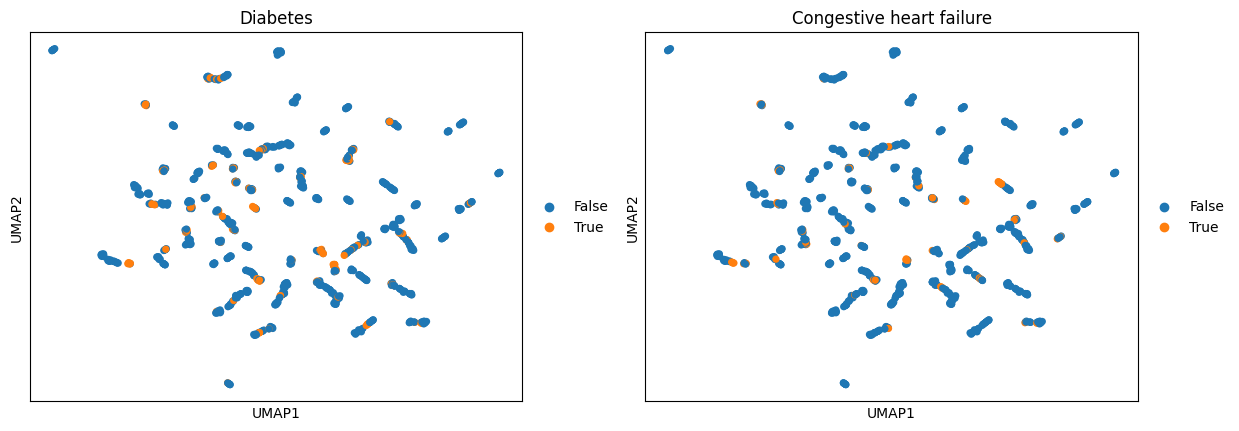

In [72]:
ep.pp.neighbors(adata_encoded)
ep.tl.umap(adata_encoded)
ep.pl.umap(adata_encoded, color=["Diabetes", "Congestive heart failure"])

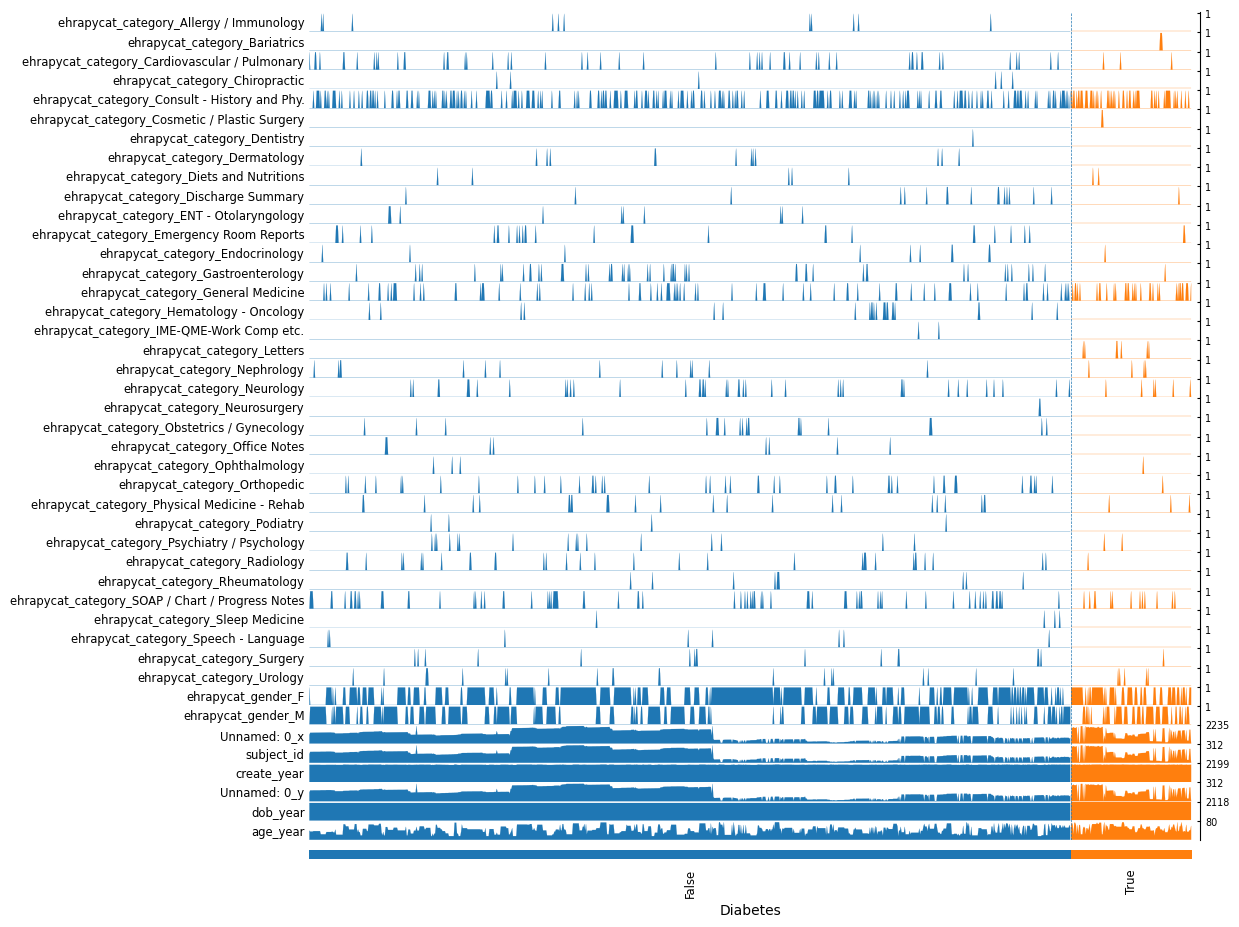

In [73]:
ep.pl.tracksplot(adata_encoded, list(adata_encoded.var_names), groupby="Diabetes")